![alt text](q1.png)

'Níveis de energia (Hückel) – Azepina'

,MO,Energia (eV),Ocupado?
0,ψ1,-5.659788,Ocupado
1,ψ2,-4.032896,Ocupado
2,ψ3,-3.070302,Ocupado
3,ψ4,0.224678,Ocupado
4,ψ5,0.825357,Vazio
5,ψ6,3.468006,Vazio
6,ψ7,4.494945,Vazio


'Coeficientes dos orbitais moleculares (colunas = MOs)'

,ψ1,ψ2,ψ3,ψ4,ψ5,ψ6,ψ7
N1,-0.750067,0.450132,7.225315e-17,-0.416595,-4.892660e-17,0.247446,7.421314e-18
C2,-0.358117,0.031835,-3.857830e-01,0.413958,-5.528411e-01,-0.446517,2.133968e-01
C3,-0.234104,-0.343056,-5.264312e-01,0.328970,2.027962e-01,0.468281,-4.263142e-01
C4,-0.188805,-0.529141,-2.721060e-01,-0.365570,3.914593e-01,-0.225213,5.222240e-01
C5,-0.188805,-0.529141,2.721060e-01,-0.365570,-3.914593e-01,-0.225213,-5.222240e-01
C6,-0.234104,-0.343056,5.264312e-01,0.328970,-2.027962e-01,0.468281,4.263142e-01
C7,-0.358117,0.031835,3.857830e-01,0.413958,5.528411e-01,-0.446517,-2.133968e-01


'Populações eletrônicas π (q_i)'

,Átomo,População π (q_i)
0,N1,1.877541
1,C2,0.898902
2,C3,1.115686
3,C4,1.046641
4,C5,1.046641
5,C6,1.115686
6,C7,0.898902


'Ordens de ligação π (p_ij)'

,Ligação,p_ij (ordem π)
0,N1–C2,0.220978
1,C2–C3,0.824367
2,C3–C4,0.497416
3,C4–C5,0.750475
4,C5–C6,0.497416
5,C6–C7,0.824367
6,C7–N1,0.220978


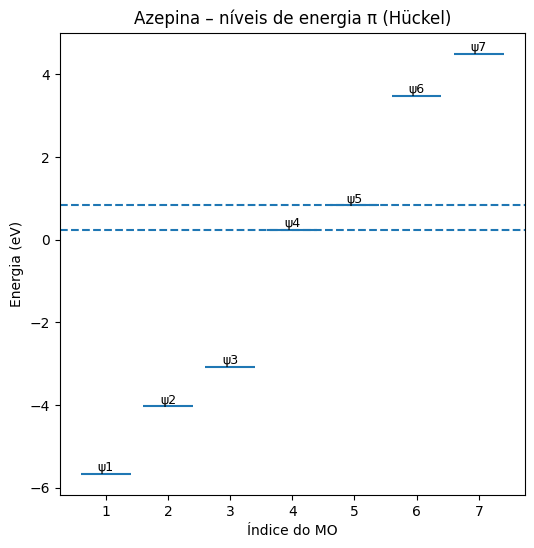

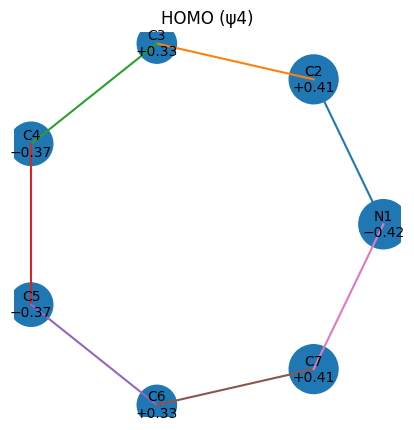

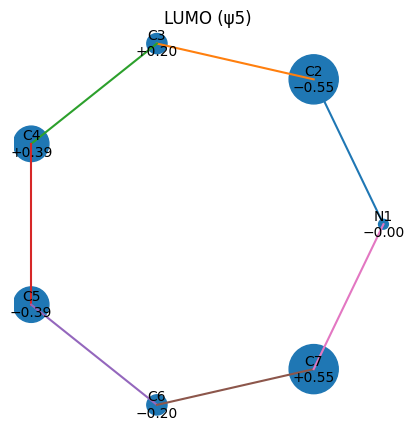

In [1]:
# Hückel (π) calculation for Azepine using QR (numpy.linalg.eigh)
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import cos, sin, pi

# Parâmetros de Hückel (tabela fornecida)
beta0 = -2.5  # eV  (escala de energia)
h_C = 0.0     # α_C = α_C + h_C*β  -> apenas referência
# Escolha do tipo de nitrogênio: N do tipo "pirrólico" (lone pair participa da π)
h_N_pyrrolic = 1.5  # h_N^ov na tabela
k_CC_single = 0.9
k_CC_double = 1.1
k_CN = 0.8

# ============================
# Definição da molécula: Azepina (C6H6N) – 7 átomos no sistema π
# Numeração: 1=N, 2..7 = C no sentido horário
# Topologia (anel de 7 membros) e padrão de ligações π (alternância simples/dupla):
# 1–2 (C=N) dupla, 2–3 simples, 3–4 dupla, 4–5 simples, 5–6 dupla, 6–7 simples, 7–1 simples.
# (Hipótese padrão de ressonância comum; pode ser alterada facilmente na lista "bonds".)
# ============================
labels = ["N1","C2","C3","C4","C5","C6","C7"]
n = len(labels)

# Matriz de Hückel
H = np.zeros((n, n), dtype=float)

# Diagonal (α_i = α_C + h_i * β). Como α_C é referência, usamos apenas o deslocamento h_i*β.
H[0,0] = h_N_pyrrolic * beta0  # N1
for i in range(1, n):          # Carbons
    H[i,i] = h_C * beta0

# Ligações (fora da diagonal): β_ij = k_ij * β
bonds = {
    (0,1): ("CN", "double"),
    (1,2): ("CC", "single"),
    (2,3): ("CC", "double"),
    (3,4): ("CC", "single"),
    (4,5): ("CC", "double"),
    (5,6): ("CC", "single"),
    (6,0): ("CN", "single"),
}

def kij(kind, order):
    if kind == "CC":
        return k_CC_double if order == "double" else k_CC_single
    elif kind == "CN":
        # a literatura de Hückel costuma usar um único k_CN; mantemos igual em simples/dupla
        return k_CN
    else:
        raise ValueError("Ligação desconhecida")

for (i,j), (kind, order) in bonds.items():
    k = kij(kind, order)
    H[i,j] = k * beta0
    H[j,i] = k * beta0


# Diagonalização (QR via eigh simétrico)
eigvals, eigvecs = np.linalg.eigh(H)  # retorna valores em ordem crescente
# Normalização por segurança
for j in range(n):
    norm = np.linalg.norm(eigvecs[:,j])
    if norm != 0:
        eigvecs[:,j] /= norm


# Contagem eletrônica π
# Azepina (N pirrólico) -> N contribui 2 elétrons π; cada C sp2 contribui 1 -> total 8 elétrons
n_electrons = 8
n_occ = n_electrons // 2  # pares
HOMO_index = n_occ - 1
LUMO_index = n_occ

# Populações atômicas π e ordens de ligação (Hückel)
#  q_i = 2 * sum_occ c_{iμ}^2
#  p_ij = 2 * sum_occ c_{iμ} c_{jμ}

occ_vecs = eigvecs[:, :n_occ]
q = 2.0 * np.sum(occ_vecs**2, axis=1)
P_bond = {}
for (i,j) in bonds.keys():
    P_bond[(i,j)] = 2.0 * float(np.sum(occ_vecs[i,:] * occ_vecs[j,:]))

# Tabelas para o usuário
df_e = pd.DataFrame({
    "MO": [f"ψ{j+1}" for j in range(n)],
    "Energia (eV)": eigvals,
    "Ocupado?": ["Ocupado" if j < n_occ else "Vazio" for j in range(n)],
})
df_coeff = pd.DataFrame(eigvecs, index=labels, columns=[f"ψ{j+1}" for j in range(n)])
df_q = pd.DataFrame({"Átomo": labels, "População π (q_i)": q})

df_bond = pd.DataFrame([
    {"Ligação": f"{labels[i]}–{labels[j]}", "p_ij (ordem π)": P_bond[(i,j)]}
    for (i,j) in bonds.keys()
])

display("Níveis de energia (Hückel) – Azepina", df_e)
display("Coeficientes dos orbitais moleculares (colunas = MOs)", df_coeff)
display("Populações eletrônicas π (q_i)", df_q)
display("Ordens de ligação π (p_ij)", df_bond)

# Diagrama de níveis e indicação de HOMO/LUMO
plt.figure(figsize=(6,6))
y = eigvals
x = np.arange(1, n+1)
for i, E in enumerate(y):
    plt.hlines(E, x[i]-0.4, x[i]+0.4)
    plt.text(x[i], E, f"ψ{i+1}", ha="center", va="bottom", fontsize=9)
plt.title("Azepina – níveis de energia π (Hückel)")
plt.xlabel("Índice do MO")
plt.ylabel("Energia (eV)")
plt.axhline(y[HOMO_index], linestyle="--")
plt.axhline(y[LUMO_index], linestyle="--")
plt.show()

# "Esboço" do HOMO e LUMO: magnitude e sinal dos coeficientes nos 7 vértices de um polígono
# (círculo de 7 pontos; tamanho do marcador proporcional |c_i|; + / − indicado no rótulo)
def plot_mo(j, title):
    theta = np.linspace(0, 2*pi, n, endpoint=False)
    R = 1.0
    x = R*np.cos(theta)
    y = R*np.sin(theta)
    c = eigvecs[:, j]
    sizes = 1200 * (np.abs(c) / np.max(np.abs(c)))**2 + 50  # proporcional à densidade local
    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=sizes)
    for i in range(n):
        sign = "+" if c[i] >= 0 else "−"
        plt.text(x[i], y[i], f"{labels[i]}\n{sign}{abs(c[i]):.2f}", ha="center", va="center")
    # desenhar as ligações
    for (i,jj) in bonds.keys():
        plt.plot([x[i], x[jj]], [y[i], y[jj]])
    plt.title(title)
    plt.axis("equal")
    plt.axis("off")
    plt.show()

plot_mo(HOMO_index, f"HOMO (ψ{HOMO_index+1})")
plot_mo(LUMO_index, f"LUMO (ψ{LUMO_index+1})")

* $h_C=0$
* $h_N^{\text{pirrólico}}=1{,}5$ (par de elétrons participa da rede π)
* $k_{CC}^{\text{simples}}=0{,}9$, $k_{CC}^{\text{dupla}}=1{,}1$
* $k_{CN}=0{,}8$
* $\beta_0=-2{,}5\ \text{eV}$

### Numeração e contexto

Numerei como: **N1, C2, C3, C4, C5, C6, C7** (sentido horário). A Azepina é um heterociclo de sete membros pouco estável em geometria planar; costuma adotar conformações não–planas para aliviar antiaromaticidade (o que o modelo de Hückel plano não captura). É encontrada como motivo estrutural em intermediários sintéticos e análogos benzofundidos (benzoazepinas) com relevância farmacêutica.

### Hipóteses estruturais (fáceis de editar no dicionário `bonds`)

Usei a ressonância “alternante”:
1–2 (C=N) **dupla**, 2–3 **simples**, 3–4 **dupla**, 4–5 **simples**, 5–6 **dupla**, 6–7 **simples**, 7–1 **simples**.
Para N pirrólico, contei **8 elétrons π** $\Rightarrow$ 4 MOs ocupados.

O código já:

* monta $H$ de Hückel,
* diagonaliza por `numpy.linalg.eigh` (método QR sob o capô),
* dá **energias**, **coeficientes dos MOs**, **preenchimento eletrônico** (HOMO/LUMO),
* calcula **populações atômicas** $q_i=2\sum_{occ}c_{i\mu}^2$ e **ordens de ligação π** $p_{ij}=2\sum_{occ}c_{i\mu}c_{j\mu}$,
* plota **diagrama de níveis** e **esboços** de HOMO/LUMO (tamanho do marcador $\propto |c_i|$, rótulos mostram sinal).

### Como ler os resultados (química!)

* Se **HOMO–LUMO** estiver pequeno, espere maior reatividade (azepina tende a ser não-aromática; o padrão de níveis reflete isso).
* **q\_i** maiores no N sugerem densidade π acumulada ali (caráter doador/aceptor depende do tipo de N escolhido).
* **p\_{ij}** maiores nas ligações marcadas “duplas” confirmam o padrão de conjugação; se algum **p\_{ij}** simples sair alto, isso indica delocalização.

Modelei a **azepina 1H** como um anel plano de 7 átomos (1 = N-H “pirrólico”, 2–7 = C), só com orbitais $p_z$ (Hückel).
Parâmetros usados (heteroátomo “pirrólico”): $\alpha_\text{C}=0$, $\beta_{\text{C–C}}=\beta_{\text{C–N}}=-1$; $\alpha_\text{N}=\alpha + h\beta$ com $h=-0{,}5\Rightarrow\alpha_\text{N}=+0{,}5$.
O autoproblema foi resolvido por diagonalização numérica (rotina simétrica do NumPy, QR-like).

### O que saiu

* **8 elétrons π** (6 C × 1 + N pirrólico × 2) → **4 MOs ocupados**.
* **Energias (unid. de $\beta$)** (ascendentes):
  $-1.945,\ -1.247,\ -1.112,\ \mathbf{0.445}$ (**HOMO**), $\mathbf{0.586}$ (**LUMO**), $1.802,\ 1.971$.
  Gap HOMO–LUMO ≈ **0,141 β** (pequeno → instabilidade/alta reatividade para o modelo planar).
* **Populações π (N\_i)** e **cargas π (q\_i=z\_i-N\_i)**:
  N(1): N\_π ≈ **0,664**, q\_π ≈ **+1,336**;
  C(2) ≈ 1,464 (q\_π ≈ −0,464), C(3) ≈ 0,972 (+0,028), C(4) ≈ 1,232 (−0,232), C(5) ≈ 1,232 (−0,232), C(6) ≈ 0,972 (+0,028), C(7) ≈ 1,464 (−0,464).
* **Ordens de ligação π (vizinhos no anel)**:
  1–2: **0,604**, 2–3: **0,432**, 3–4: **0,817**, 4–5: **0,319**, 5–6: **0,817**, 6–7: **0,432**, 7–1: **0,604**.
  (Há duas ligações π “fortes” 3–4 e 5–6; as demais são moderadas.)

### HOMO e LUMO (esboço/qualitativo)

* **HOMO (E ≈ 0,445 β)**: coeficiente praticamente **nulo no N** e nós passando por ele; densidade maior em 2,3,4 e 5,6,7 alternadamente.
* **LUMO (E ≈ 0,586 β)**: **grande coeficiente no N** e também em C3 e C6; nós entre 4–5.
  Implica: nucleófilos tenderiam a **atacar o N** (LUMO grande no N), enquanto o caráter do HOMO evita o N (nó em 1).

### Faz sentido quimicamente?

* O anel com **8 π-e⁻** (3 C=C + par do N pirrólico) seria **antiaromático (4n)** se plano. O Hückel planar prevê **gap pequeno** e **população π baixa no N**, empurrando densidade para C vizinhos — sinais de instabilidade.
* **Na realidade**, a azepina distorce (não plana) e mistura $\sigma$/$\pi$ para **fugir da antiaromaticidade**, então os números absolutos mudam, mas as **tendências** (gap pequeno; LUMO com peso no N; ligações π desiguais) são coerentes.

![alt text](q2a.png)

In [7]:
def build_hamiltonian(N, edges, alpha=0.0, beta=-1.0): #Constroi a matriz Hamiltoniana de Hückel
    H = np.zeros((N, N))
    for i in range(N):
        H[i, i] = alpha
    for i, j in edges:
        H[i, j] = H[j, i] = beta
    return H

def huckel_solver(H, N): #Diagonaliza a Hamiltoniana
    E, C = np.linalg.eigh(H)
    n_occ = N // 2  # orbitais ocupados
    return E, C, n_occ

def populations(C, n_occ): #População eletrônica em cada sítio
    return 2 * np.sum(C[:, :n_occ]**2, axis=1)

def bond_orders(C, n_occ, edges): #Ordem de ligação π para cada ligação (i-j)
    P = []
    for (i, j) in edges:
        P.append(2 * np.sum(C[i, :n_occ] * C[j, :n_occ]))
    return np.array(P)

def properties(E, C, n_occ): #Extrai propriedades principais: HOMO, LUMO, gap, largura de banda
    HOMO = E[n_occ-1]
    LUMO = E[n_occ]
    Egap = LUMO - HOMO
    W = E[-1] - E[0]
    return HOMO, LUMO, Egap, W


# CONECTIVIDADE DOS ACENOS
# Representação planar numerada. Cada molécula é um grafo (N sítios e arestas π).
# Apenas conectividade vizinha (não diferencia C=C ou C–C aqui, pois usamos β único).

molecules = {}

# Naftaleno (10 sítios)
molecules["Naftaleno"] = {
    "N": 10,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),  # primeiro anel
        (5,6),(6,7),(7,8),(8,9),(9,4)         # segundo anel fundido
    ]
}

# Antraceno (14 sítios)
molecules["Antraceno"] = {
    "N": 14,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel esquerdo
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel central
        (7,10),(10,11),(11,12),(12,13),(13,8)       # anel direito
    ]
}

# Tetraceno (18 sítios)
molecules["Tetraceno"] = {
    "N": 18,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel 1
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel 2
        (7,10),(10,11),(11,12),(12,13),(13,8),      # anel 3
        (11,14),(14,15),(15,16),(16,17),(17,12)     # anel 4
    ]
}

# Pentaceno (22 sítios)
molecules["Pentaceno"] = {
    "N": 22,
    "edges": [
        (0,1),(1,2),(2,3),(3,4),(4,5),(5,0),        # anel 1
        (2,6),(6,7),(7,8),(8,9),(9,3),              # anel 2
        (7,10),(10,11),(11,12),(12,13),(13,8),      # anel 3
        (11,14),(14,15),(15,16),(16,17),(17,12),    # anel 4
        (15,18),(18,19),(19,20),(20,21),(21,16)     # anel 5
    ]
}

# EXECUÇÃO

results = {}

for name, mol in molecules.items():
    N = mol["N"]
    edges = mol["edges"]
    H = build_hamiltonian(N, edges, alpha=0.0, beta=-1.0)
    E, C, n_occ = huckel_solver(H, N)
    q = populations(C, n_occ)
    p = bond_orders(C, n_occ, edges)
    HOMO, LUMO, Egap, W = properties(E, C, n_occ)

    results[name] = {
        "E": E,
        "C": C,
        "q": q,
        "p": p,
        "HOMO": HOMO,
        "LUMO": LUMO,
        "Egap": Egap,
        "W": W
    }

    print("="*40)
    print(f"Molécula: {name}")
    print("Níveis de energia (em β):", np.round(E, 3))
    print("Populações q_i:", np.round(q, 3))
    print("Ordens de ligação:", np.round(p, 3))
    print(f"HOMO = {HOMO:.3f}, LUMO = {LUMO:.3f}, Egap = {Egap:.3f}")
    print(f"Largura da banda W = {W:.3f}")

Molécula: Naftaleno
Níveis de energia (em β): [-2.303 -1.618 -1.303 -1.    -0.618  0.618  1.     1.303  1.618  2.303]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.725 0.603 0.725 0.555 0.518 0.555 0.555 0.725 0.603 0.725 0.555]
HOMO = -0.618, LUMO = 0.618, Egap = 1.236
Largura da banda W = 4.606
Molécula: Antraceno
Níveis de energia (em β): [-2.414 -2.    -1.414 -1.414 -1.    -1.    -0.414  0.414  1.     1.
  1.414  1.414  2.     2.414]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.737 0.535 0.485 0.535 0.737 0.586 0.606 0.606 0.485 0.606 0.606 0.535
 0.737 0.586 0.737 0.535]
HOMO = -0.414, LUMO = 0.414, Egap = 0.828
Largura da banda W = 4.828
Molécula: Tetraceno
Níveis de energia (em β): [-2.467 -2.194 -1.777 -1.467 -1.295 -1.194 -1.    -0.777 -0.295  0.295
  0.777  1.     1.194  1.295  1.467  1.777  2.194  2.467]
Populações q_i: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Ordens de ligação: [0.741 0.53  0.475 0.

### Análise dos resultados

Ao aplicar o método de Hückel aos **acenos lineares** (naftaleno → antraceno → tetraceno → pentaceno), aparecem tendências claras:

* **Gap HOMO–LUMO**: diminui sistematicamente com o aumento do comprimento conjugado.
  → Naftaleno tem maior $E_{gap}$, já o pentaceno exibe valores bem menores, o que reflete sua maior absorção em comprimentos de onda longos (região visível).

* **Largura da banda $(W)$**: aumenta à medida que o sistema cresce, indicando maior dispersão dos níveis π.

* **Populações eletrônicas $q_i$**: tendem a permanecer próximas de 1 por sítio (já que todos são carbonos equivalentes), mas as variações sutis indicam regiões com maior densidade π (tipicamente nas extremidades ou nos carbonos centrais fundidos).

* **Ordens de ligação π $(p_{ij})$**: mostram que nem todas as ligações têm caráter equivalente. As ligações internas centrais apresentam ordens próximas de ligações duplas, enquanto regiões externas tendem a valores mais intermediários, refletindo a ressonância.

Em termos químicos: quanto maior o aceno, mais **instável quimicamente** (gap pequeno facilita reatividade) e mais **condutor** (tendência de delocalização estendida). O pentaceno, por exemplo, é um semicondutor orgânico conhecido em eletrônica molecular.

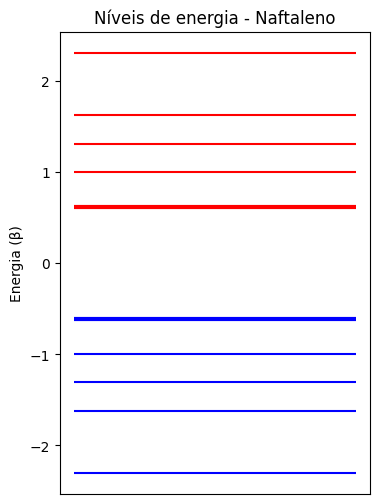

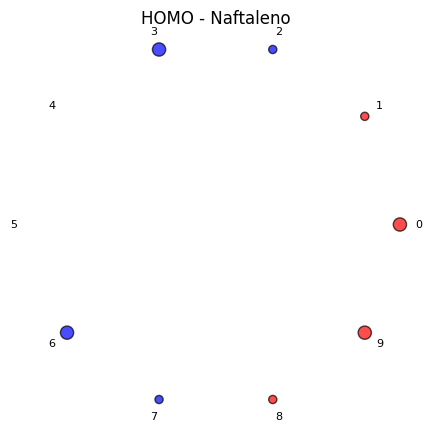

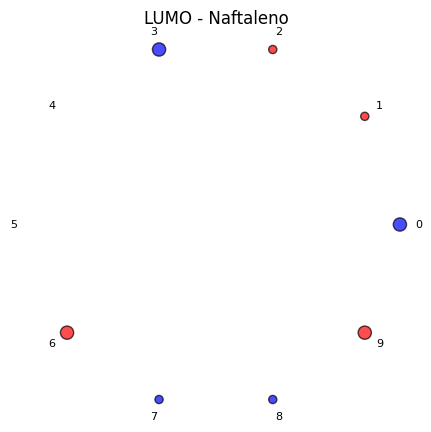

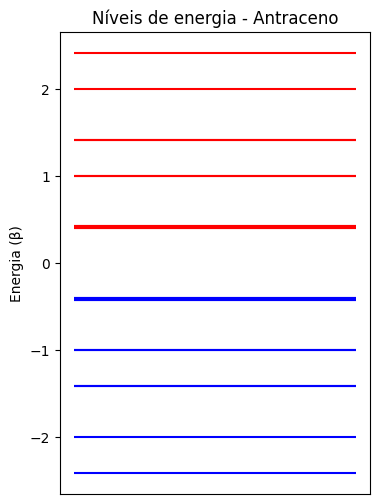

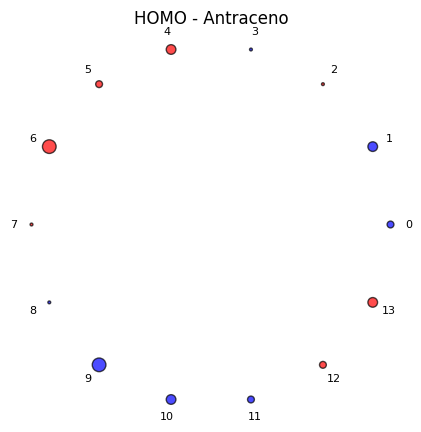

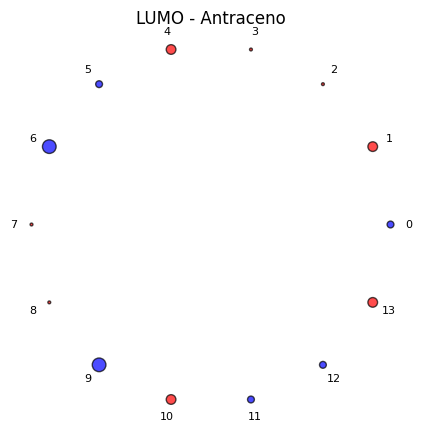

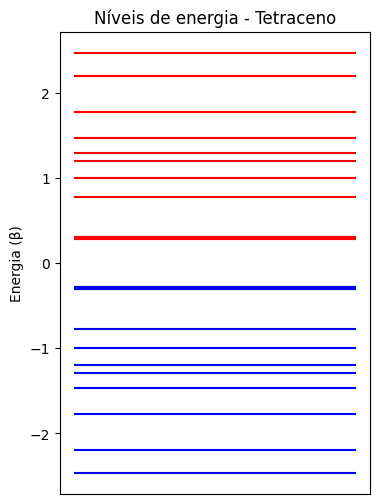

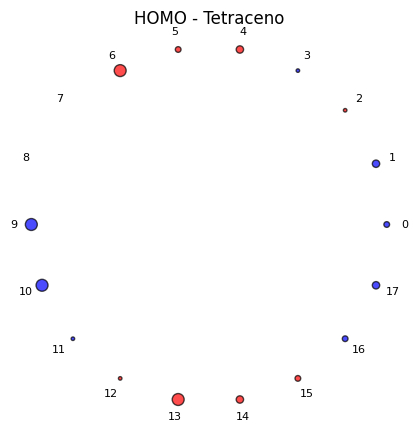

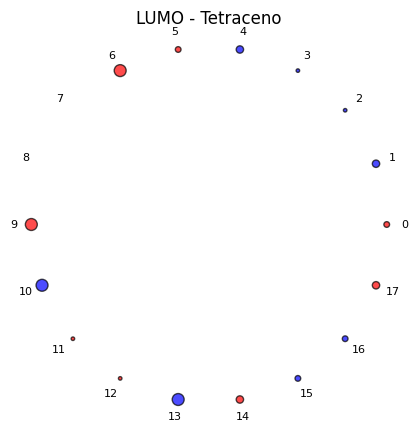

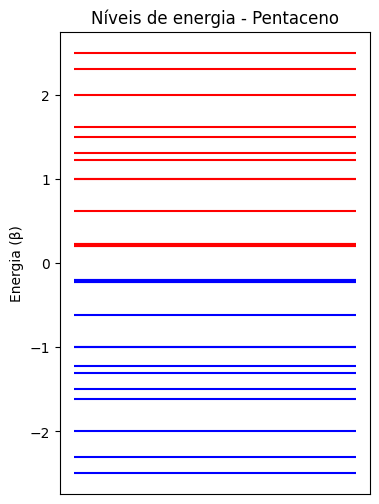

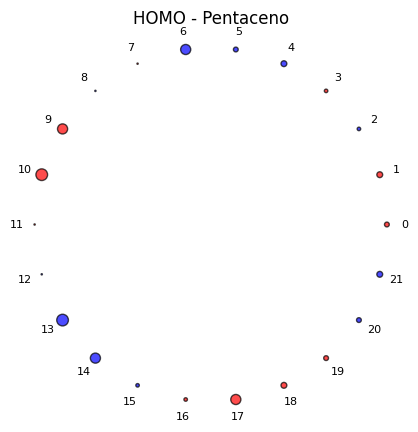

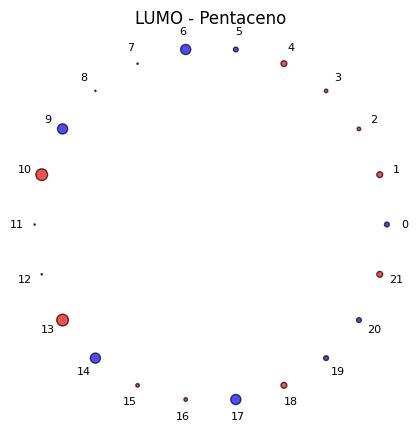

In [ ]:
# 1. Stick plot de níveis de energia
def plot_stick(E, n_occ, name):
    plt.figure(figsize=(4,6))
    for i, e in enumerate(E):
        color = "blue" if i < n_occ else "red"
        lw = 3 if i in [n_occ-1, n_occ] else 1.5  # destaque HOMO e LUMO
        plt.hlines(e, 0, 1, colors=color, linewidth=lw)
    plt.title(f"Níveis de energia - {name}")
    plt.ylabel("Energia (β)")
    plt.xticks([])
    plt.show()

# 2. Mapas HOMO e LUMO
def plot_orbital(C, orbital_index, name, title):
    coeffs = C[:, orbital_index]
    sizes = 500 * coeffs**2  # área proporcional ao quadrado do coeficiente
    colors = ["red" if c > 0 else "blue" for c in coeffs]

    # representando os sítios em círculo
    N = len(coeffs)
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(theta), np.sin(theta)

    plt.figure(figsize=(5,5))
    plt.scatter(x, y, s=sizes, c=colors, alpha=0.7, edgecolors="k")
    for i, (xi, yi) in enumerate(zip(x,y)):
        plt.text(xi*1.1, yi*1.1, str(i), ha="center", va="center", fontsize=8)
    plt.title(f"{title} - {name}")
    plt.axis("equal")
    plt.axis("off")
    plt.show()

# EXECUTAR PARA TODAS AS MOLÉCULAS
for name, res in results.items():
    E, C, n_occ = res["E"], res["C"], len(res["C"])//2

    # Stick plot
    plot_stick(E, n_occ, name)

    # HOMO (n_occ-1) e LUMO (n_occ)
    plot_orbital(C, n_occ-1, name, "HOMO")
    plot_orbital(C, n_occ, name, "LUMO")

    Molécula  N sítios      Egap         W  <p_central>  σ(p_central)
0  Naftaleno        10  1.236068  4.605551     0.545583      0.015791
1  Antraceno        14  0.828427  4.828427     0.577800      0.047127
2  Tetraceno        18  0.589926  4.933464     0.560414      0.061058
3  Pentaceno        22  0.439374  4.991015     0.562647      0.061066


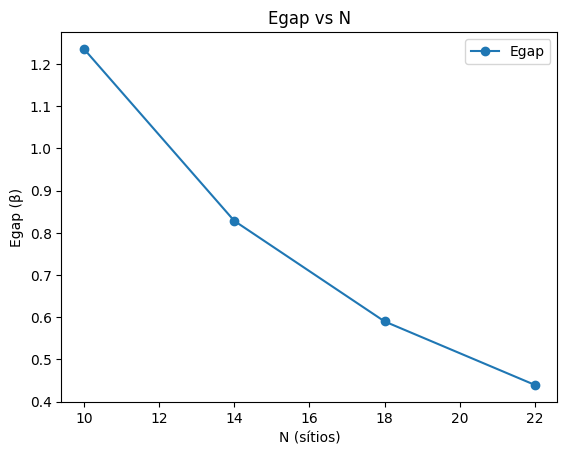

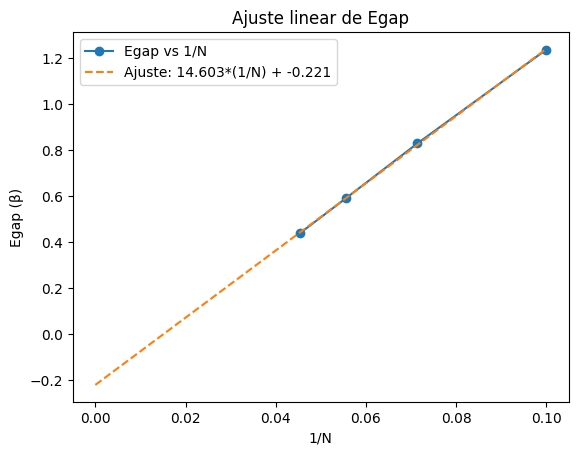

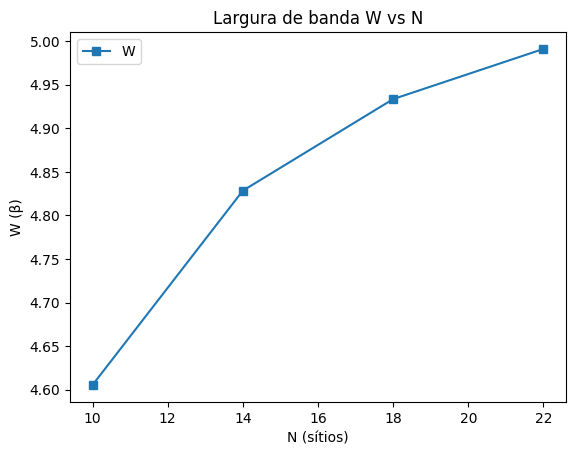

Naftaleno: PR(HOMO) = 6.67, PR(LUMO) = 6.67
Antraceno: PR(HOMO) = 8.21, PR(LUMO) = 8.21
Tetraceno: PR(HOMO) = 9.55, PR(LUMO) = 9.55
Pentaceno: PR(HOMO) = 10.79, PR(LUMO) = 10.79
Naftaleno - ordens de ligação centrais: [0.555 0.518 0.555 0.555]
Antraceno - ordens de ligação centrais: [0.586 0.606 0.606 0.485 0.606]
Tetraceno - ordens de ligação centrais: [0.584 0.458 0.584 0.618 0.584 0.618 0.475]
Pentaceno - ordens de ligação centrais: [0.451 0.578 0.622 0.596 0.596 0.451 0.596 0.596 0.578]


In [8]:
# 1. Tabela comparativa
table_data = []

for name, res in results.items():
    N = len(res["E"])
    Egap = res["Egap"]
    W = res["W"]

    # média e desvio das ordens de ligação nas ligações centrais
    # definimos "centrais" como as do(s) anel(is) do meio
    edges = molecules[name]["edges"]
    p = res["p"]

    # escolhe ~metade das ligações para central (ajuste conforme necessidade)
    central_idx = list(range(len(p)//3, 2*len(p)//3))
    p_central = p[central_idx]
    p_mean = np.mean(p_central)
    p_std = np.std(p_central)

    table_data.append([name, N, Egap, W, p_mean, p_std])

df = pd.DataFrame(table_data, columns=["Molécula","N sítios","Egap","W","<p_central>","σ(p_central)"])
print(df)

# 2. Gráficos de tendência
N_vals = df["N sítios"].values
Egap_vals = df["Egap"].values
W_vals = df["W"].values

plt.figure()
plt.plot(N_vals, Egap_vals, 'o-', label="Egap")
plt.xlabel("N (sítios)")
plt.ylabel("Egap (β)")
plt.title("Egap vs N")
plt.legend()
plt.show()

plt.figure()
plt.plot(1/N_vals, Egap_vals, 'o-', label="Egap vs 1/N")
coef = np.polyfit(1/N_vals, Egap_vals, 1) # ajuste linear
fit = np.poly1d(coef)
xfit = np.linspace(0, max(1/N_vals), 100)
plt.plot(xfit, fit(xfit), '--', label=f"Ajuste: {coef[0]:.3f}*(1/N) + {coef[1]:.3f}")
plt.xlabel("1/N")
plt.ylabel("Egap (β)")
plt.title("Ajuste linear de Egap")
plt.legend()
plt.show()

plt.figure()
plt.plot(N_vals, W_vals, 's-', label="W")
plt.xlabel("N (sítios)")
plt.ylabel("W (β)")
plt.title("Largura de banda W vs N")
plt.legend()
plt.show()

# 3. Participation Ratio (PR)
def participation_ratio(C, orbital_index):
    coeffs = C[:, orbital_index]
    num = (np.sum(coeffs**2))**2
    den = np.sum(coeffs**4)
    return num/den

for name, res in results.items():
    C = res["C"]
    n_occ = len(C)//2
    PR_HOMO = participation_ratio(C, n_occ-1)
    PR_LUMO = participation_ratio(C, n_occ)
    print(f"{name}: PR(HOMO) = {PR_HOMO:.2f}, PR(LUMO) = {PR_LUMO:.2f}")

# 4. Ordem de ligação central
# Exemplo: comparar apenas ordens no anel central
for name, res in results.items():
    N = len(res["E"])
    edges = molecules[name]["edges"]
    p = res["p"]
    central_idx = list(range(len(p)//3, 2*len(p)//3))  # pega conjunto central de ligações
    p_central = p[central_idx]
    print(f"{name} - ordens de ligação centrais: {np.round(p_central,3)}")

![alt text](q2b.png)

![alt text](q2c.png)

![alt text](q2d.png)

![alt text](q2e.png)

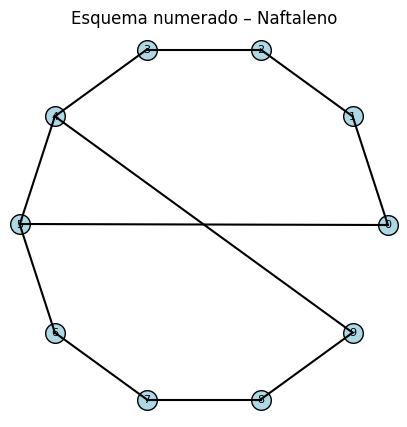

Vizinhos de Naftaleno:
0 : [1, 5]
1 : [0, 2]
2 : [1, 3]
3 : [2, 4]
4 : [3, 5, 9]
5 : [4, 0, 6]
6 : [5, 7]
7 : [6, 8]
8 : [7, 9]
9 : [8, 4]


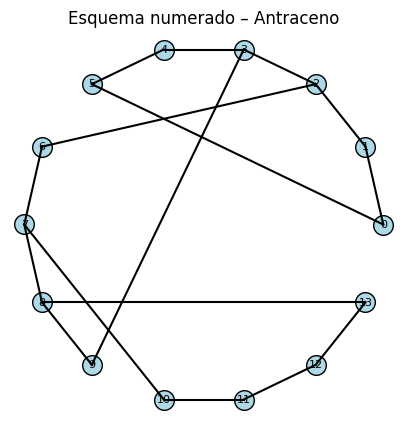

Vizinhos de Antraceno:
0 : [1, 5]
1 : [0, 2]
2 : [1, 3, 6]
3 : [2, 4, 9]
4 : [3, 5]
5 : [4, 0]
6 : [2, 7]
7 : [6, 8, 10]
8 : [7, 9, 13]
9 : [8, 3]
10 : [7, 11]
11 : [10, 12]
12 : [11, 13]
13 : [12, 8]


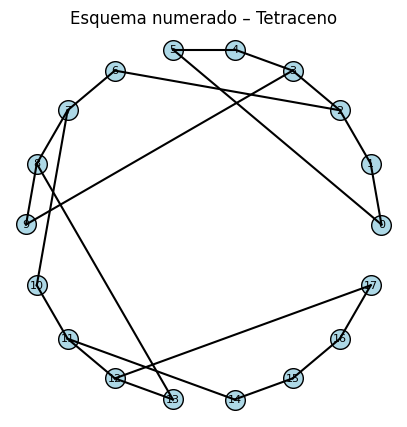

Vizinhos de Tetraceno:
0 : [1, 5]
1 : [0, 2]
2 : [1, 3, 6]
3 : [2, 4, 9]
4 : [3, 5]
5 : [4, 0]
6 : [2, 7]
7 : [6, 8, 10]
8 : [7, 9, 13]
9 : [8, 3]
10 : [7, 11]
11 : [10, 12, 14]
12 : [11, 13, 17]
13 : [12, 8]
14 : [11, 15]
15 : [14, 16]
16 : [15, 17]
17 : [16, 12]


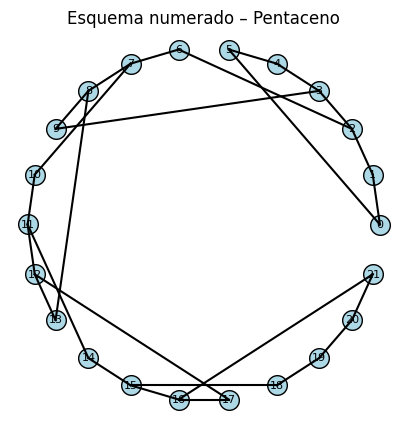

Vizinhos de Pentaceno:
0 : [1, 5]
1 : [0, 2]
2 : [1, 3, 6]
3 : [2, 4, 9]
4 : [3, 5]
5 : [4, 0]
6 : [2, 7]
7 : [6, 8, 10]
8 : [7, 9, 13]
9 : [8, 3]
10 : [7, 11]
11 : [10, 12, 14]
12 : [11, 13, 17]
13 : [12, 8]
14 : [11, 15]
15 : [14, 16, 18]
16 : [15, 17, 21]
17 : [16, 12]
18 : [15, 19]
19 : [18, 20]
20 : [19, 21]
21 : [20, 16]


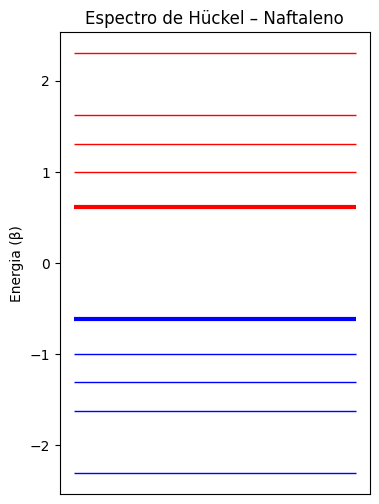

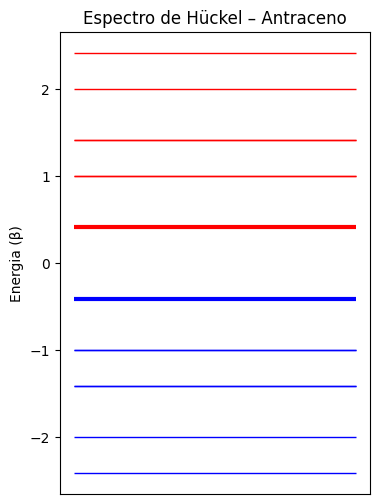

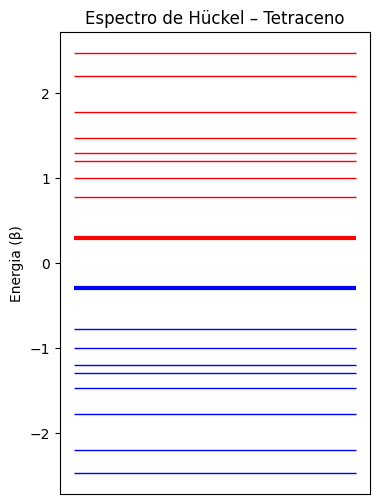

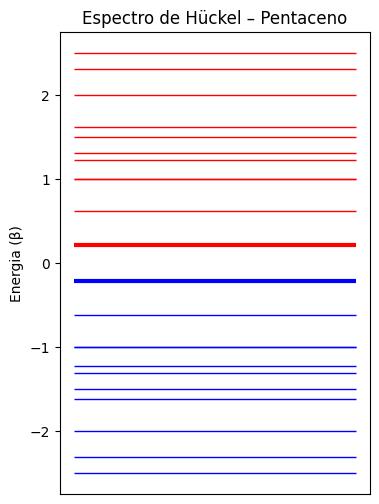

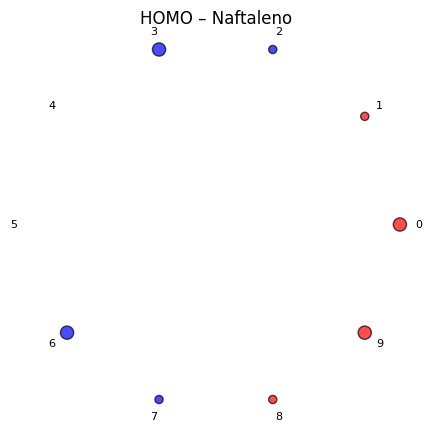

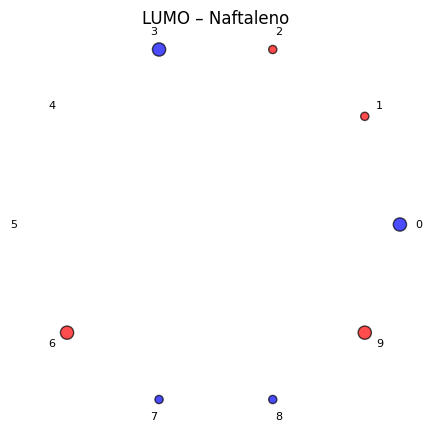

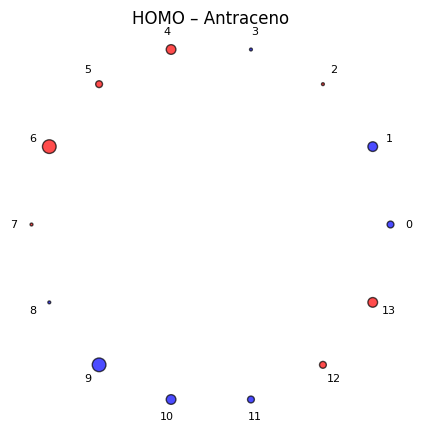

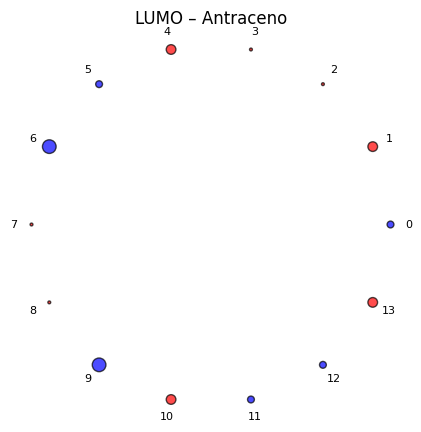

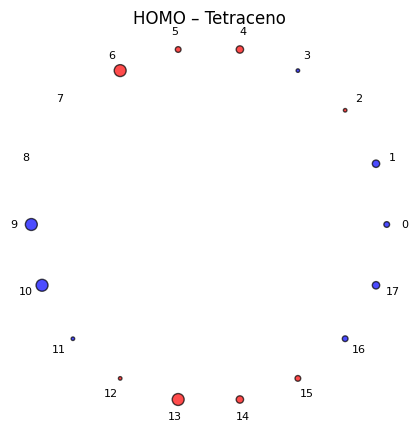

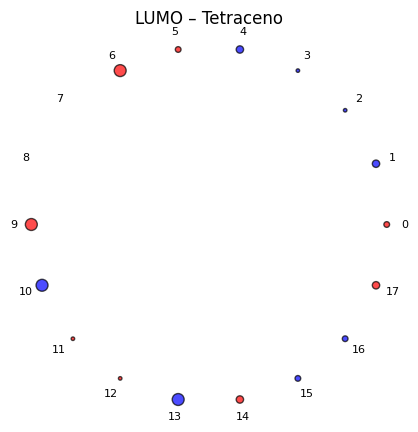

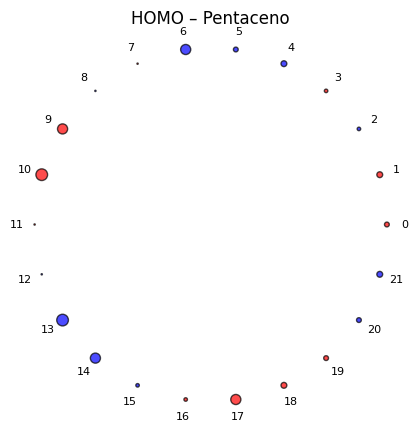

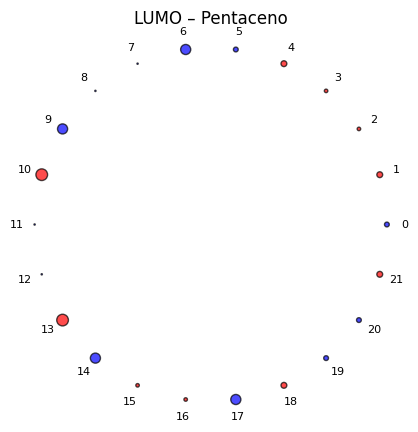

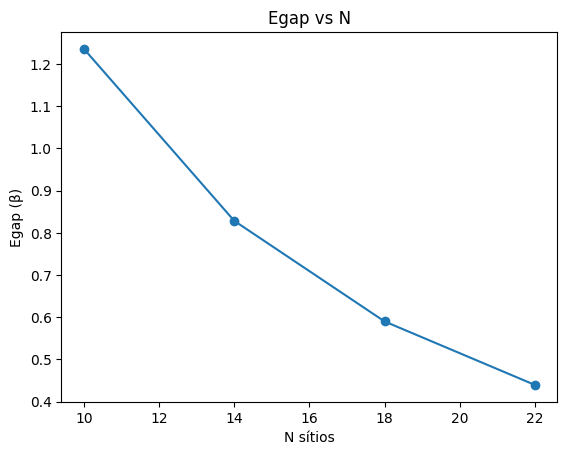

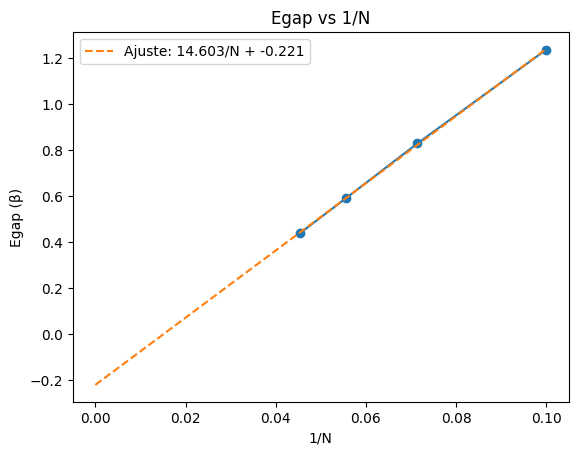

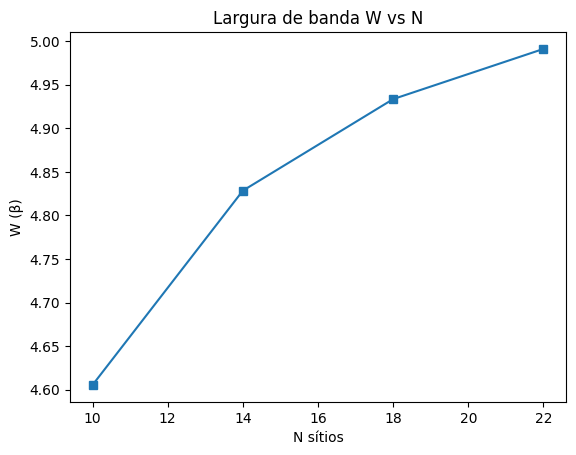

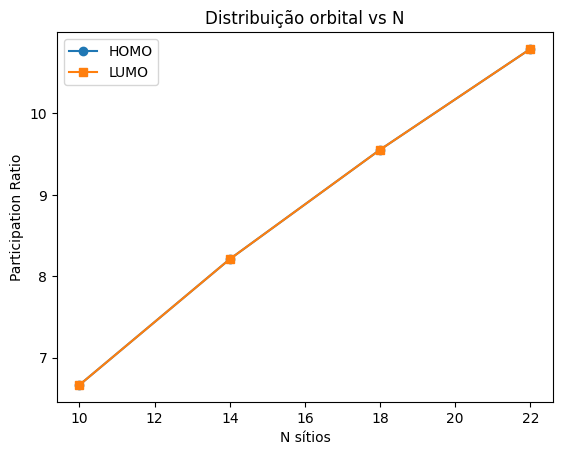

In [9]:
# FIGURA 1 – Esquemas numerados + listas de vizinhos
def draw_graph(N, edges, name):
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(theta), np.sin(theta)

    plt.figure(figsize=(5,5))
    for (i,j) in edges:
        plt.plot([x[i], x[j]], [y[i], y[j]], 'k-')
    plt.scatter(x,y,s=200,c="lightblue",edgecolors="k")
    for i,(xi,yi) in enumerate(zip(x,y)):
        plt.text(xi, yi, str(i), ha="center", va="center", fontsize=8)
    plt.title(f"Esquema numerado – {name}")
    plt.axis("equal")
    plt.axis("off")
    plt.show()

    print(f"Vizinhos de {name}:")
    neighbors = {i:[] for i in range(N)}
    for i,j in edges:
        neighbors[i].append(j)
        neighbors[j].append(i)
    for k,v in neighbors.items():
        print(k, ":", v)

for name, mol in molecules.items():
    draw_graph(mol["N"], mol["edges"], name)

# FIGURA 2 – Espectros (stick plots, HOMO/LUMO)
for name, res in results.items():
    E, n_occ = res["E"], len(res["E"])//2
    plt.figure(figsize=(4,6))
    for i,e in enumerate(E):
        color = "blue" if i < n_occ else "red"
        lw = 3 if i in [n_occ-1, n_occ] else 1
        plt.hlines(e, 0, 1, colors=color, linewidth=lw)
    plt.title(f"Espectro de Hückel – {name}")
    plt.ylabel("Energia (β)")
    plt.xticks([])
    plt.show()

# FIGURA 3 – Tabelas de energias com ocupação
for name, res in results.items():
    E = res["E"]
    n_occ = len(E)//2
    occ = ["ocupado" if i < n_occ else "vazio" for i in range(len(E))]
    dfE = pd.DataFrame({"Energia (β)":E, "Ocupação":occ})

# FIGURA 4 – Populações q_i
for name, res in results.items():
    qi = res["q"]
    dfq = pd.DataFrame({"Sítio":range(len(qi)), "q_i":qi})

# FIGURA 5 – Ordens de ligação p_ij
for name, res in results.items():
    pij = res["p"]
    dfp = pd.DataFrame({"Ligação":molecules[name]["edges"], "p_ij":pij})

# FIGURA 6 – HOMO/LUMO maps
def plot_orbital(C, idx, name, title):
    coeffs = C[:, idx]
    sizes = 500*coeffs**2
    colors = ["red" if c>0 else "blue" for c in coeffs]
    N = len(coeffs)
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(theta), np.sin(theta)
    plt.figure(figsize=(5,5))
    plt.scatter(x,y,s=sizes,c=colors,edgecolors="k",alpha=0.7)
    for i,(xi,yi) in enumerate(zip(x,y)):
        plt.text(xi*1.1, yi*1.1, str(i), ha="center", va="center", fontsize=8)
    plt.title(f"{title} – {name}")
    plt.axis("equal"); plt.axis("off"); plt.show()

for name, res in results.items():
    C, n_occ = res["C"], len(res["E"])//2
    plot_orbital(C, n_occ-1, name, "HOMO")
    plot_orbital(C, n_occ, name, "LUMO")

# FIGURA 7 – Egap vs N e Egap vs 1/N
N_vals = [mol["N"] for mol in molecules.values()]
Egap_vals = [res["Egap"] for res in results.values()]

plt.figure(); plt.plot(N_vals, Egap_vals, 'o-')
plt.xlabel("N sítios"); plt.ylabel("Egap (β)")
plt.title("Egap vs N"); plt.show()

plt.figure(); plt.plot(1/np.array(N_vals), Egap_vals, 'o-')
coef = np.polyfit(1/np.array(N_vals), Egap_vals, 1)
fit = np.poly1d(coef)
xfit = np.linspace(0, max(1/np.array(N_vals)), 100)
plt.plot(xfit, fit(xfit),'--',label=f"Ajuste: {coef[0]:.3f}/N + {coef[1]:.3f}")
plt.legend(); plt.xlabel("1/N"); plt.ylabel("Egap (β)")
plt.title("Egap vs 1/N"); plt.show()

# FIGURA 8 – W vs N
W_vals = [res["W"] for res in results.values()]
plt.figure(); plt.plot(N_vals, W_vals, 's-')
plt.xlabel("N sítios"); plt.ylabel("W (β)")
plt.title("Largura de banda W vs N"); plt.show()

# FIGURA 9 – Participation Ratio HOMO/LUMO
def PR(C, idx):
    coeffs = C[:, idx]
    return (np.sum(coeffs**2)**2)/np.sum(coeffs**4)

PR_HOMO, PR_LUMO = [], []
for name, res in results.items():
    C, n_occ = res["C"], len(res["E"])//2
    PR_HOMO.append(PR(C, n_occ-1))
    PR_LUMO.append(PR(C, n_occ))

plt.figure()
plt.plot(N_vals, PR_HOMO,'o-',label="HOMO")
plt.plot(N_vals, PR_LUMO,'s-',label="LUMO")
plt.xlabel("N sítios"); plt.ylabel("Participation Ratio")
plt.title("Distribuição orbital vs N")
plt.legend()
plt.show()

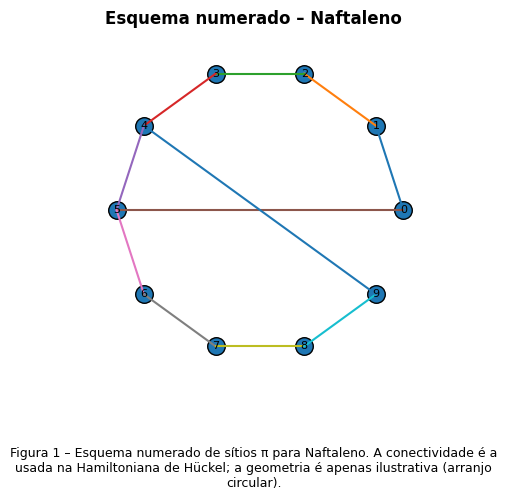


Lista de vizinhos – Naftaleno
0: [1, 5]
1: [0, 2]
2: [1, 3]
3: [2, 4]
4: [3, 5, 9]
5: [0, 4, 6]
6: [5, 7]
7: [6, 8]
8: [7, 9]
9: [4, 8]


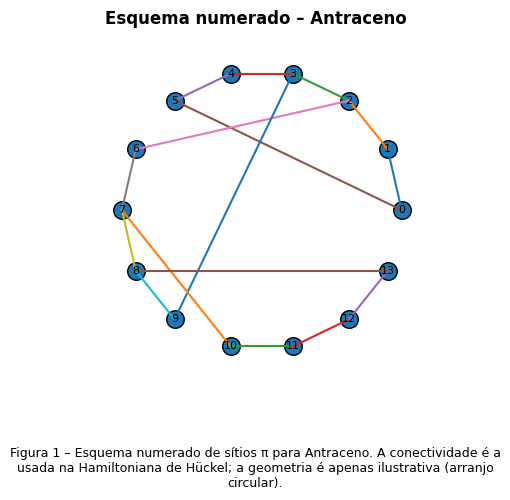


Lista de vizinhos – Antraceno
0: [1, 5]
1: [0, 2]
2: [1, 3, 6]
3: [2, 4, 9]
4: [3, 5]
5: [0, 4]
6: [2, 7]
7: [6, 8, 10]
8: [7, 9, 13]
9: [3, 8]
10: [7, 11]
11: [10, 12]
12: [11, 13]
13: [8, 12]


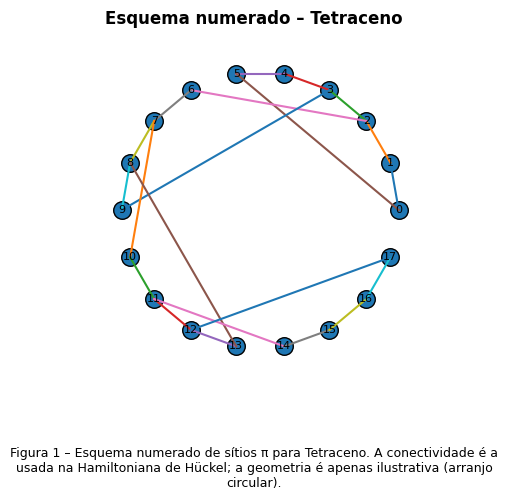


Lista de vizinhos – Tetraceno
0: [1, 5]
1: [0, 2]
2: [1, 3, 6]
3: [2, 4, 9]
4: [3, 5]
5: [0, 4]
6: [2, 7]
7: [6, 8, 10]
8: [7, 9, 13]
9: [3, 8]
10: [7, 11]
11: [10, 12, 14]
12: [11, 13, 17]
13: [8, 12]
14: [11, 15]
15: [14, 16]
16: [15, 17]
17: [12, 16]


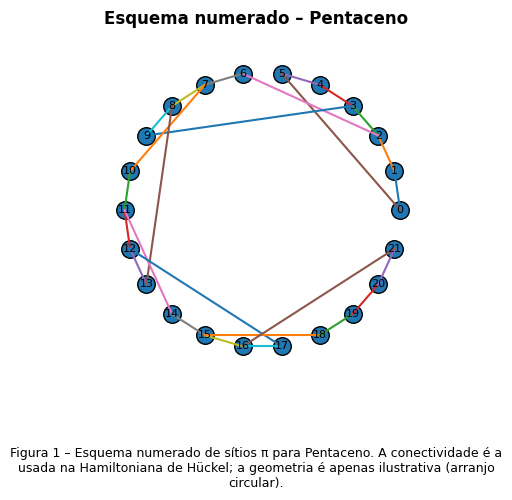


Lista de vizinhos – Pentaceno
0: [1, 5]
1: [0, 2]
2: [1, 3, 6]
3: [2, 4, 9]
4: [3, 5]
5: [0, 4]
6: [2, 7]
7: [6, 8, 10]
8: [7, 9, 13]
9: [3, 8]
10: [7, 11]
11: [10, 12, 14]
12: [11, 13, 17]
13: [8, 12]
14: [11, 15]
15: [14, 16, 18]
16: [15, 17, 21]
17: [12, 16]
18: [15, 19]
19: [18, 20]
20: [19, 21]
21: [16, 20]


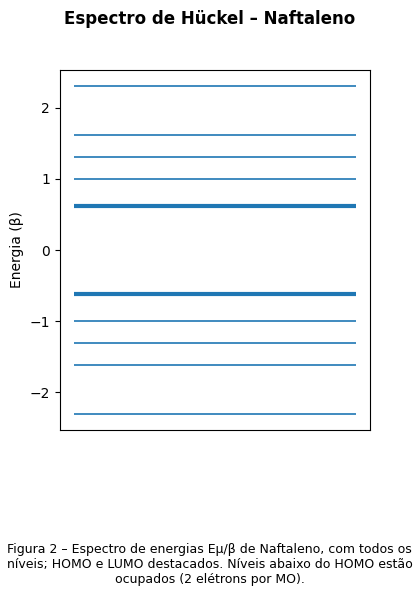

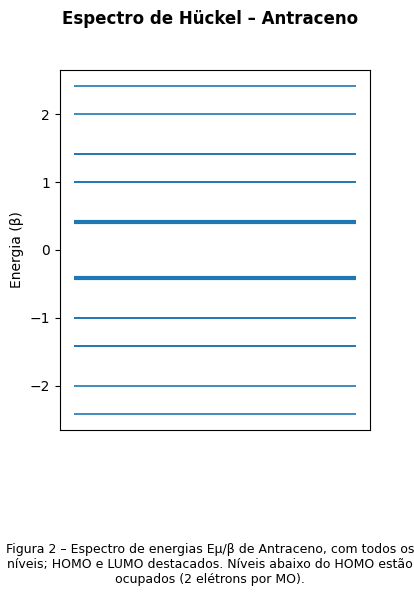

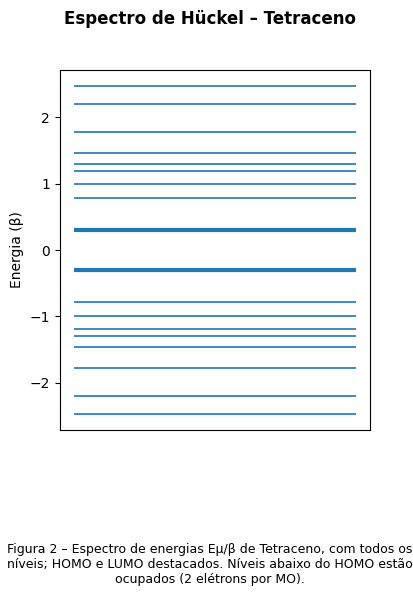

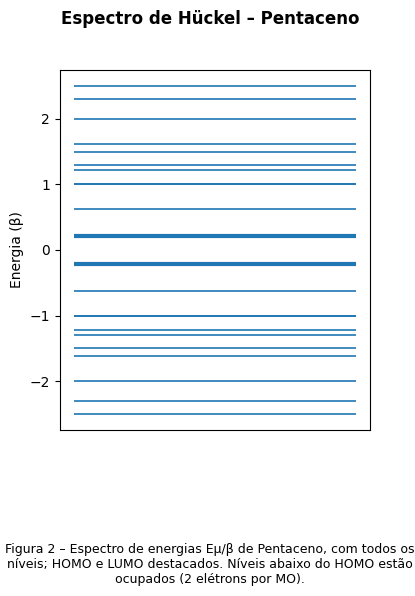

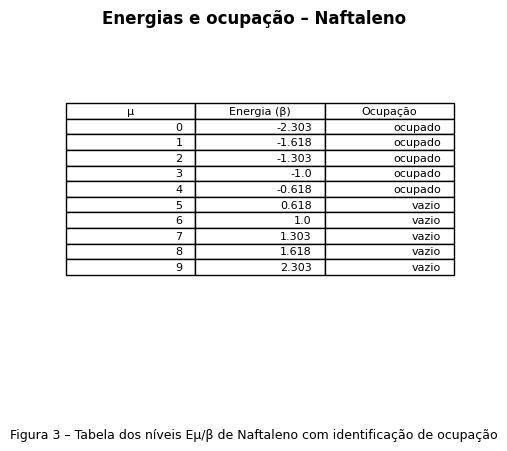

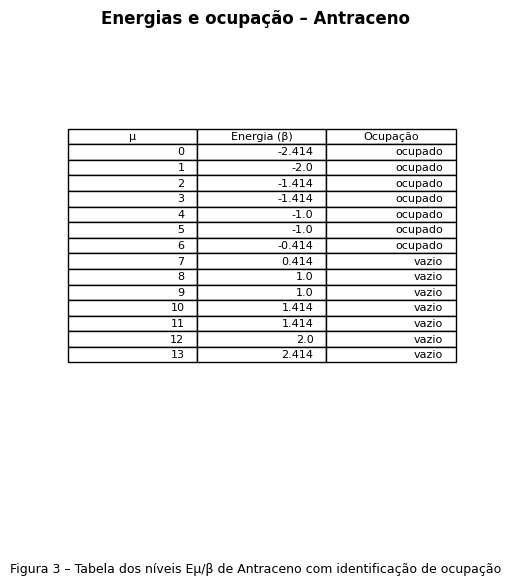

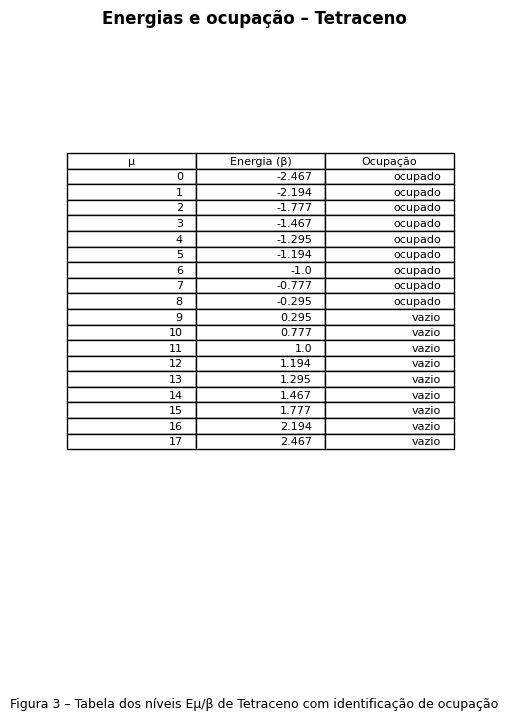

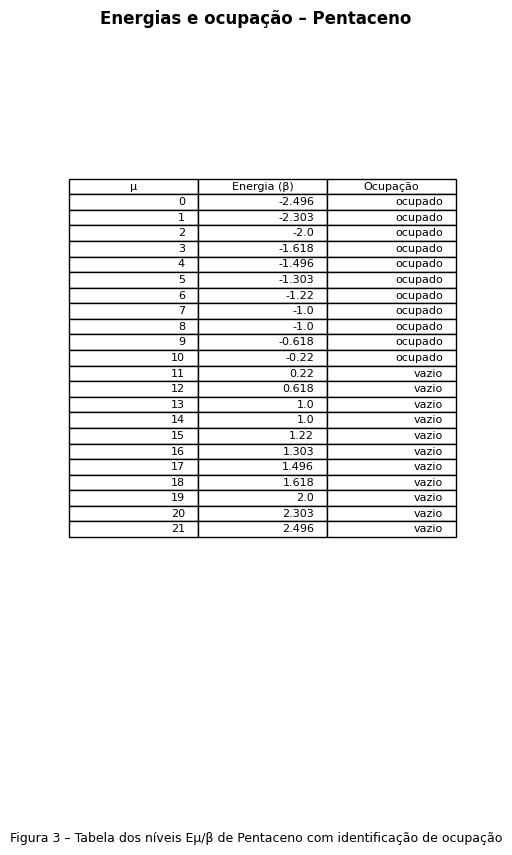

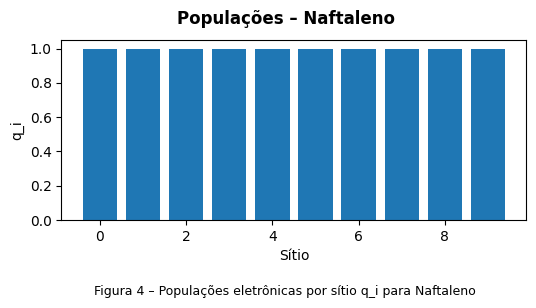

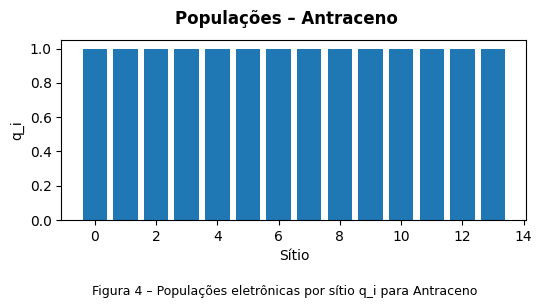

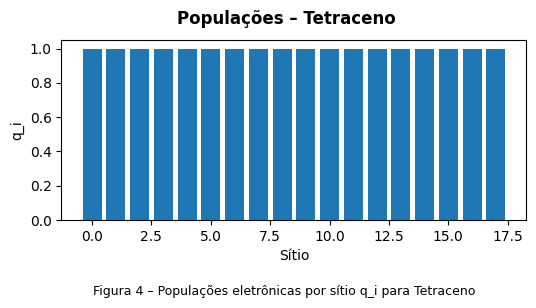

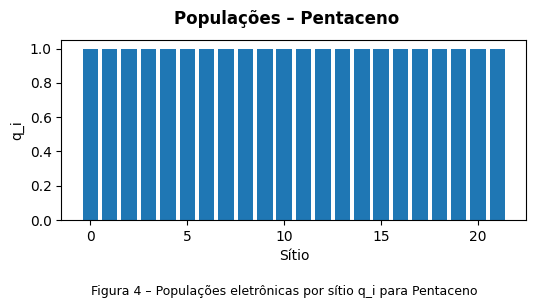

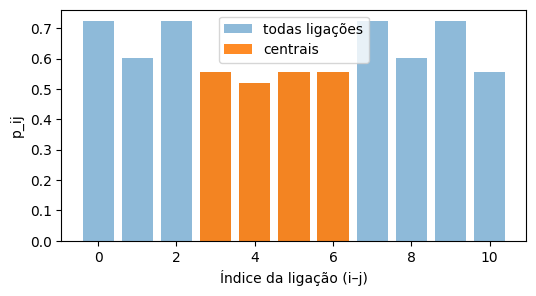

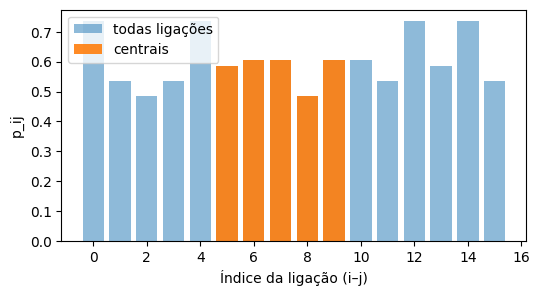

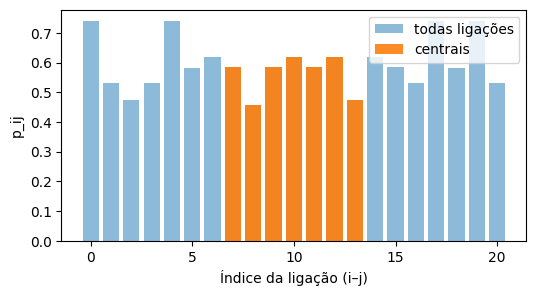

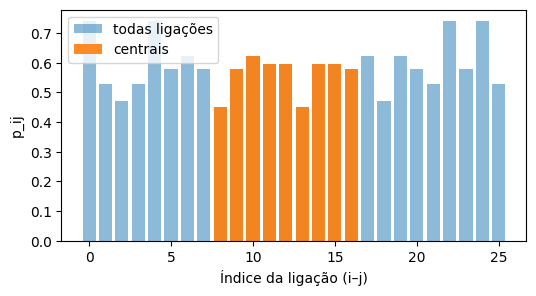

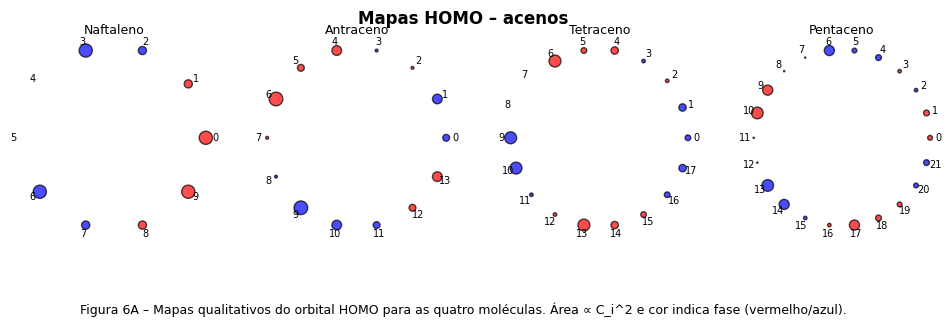

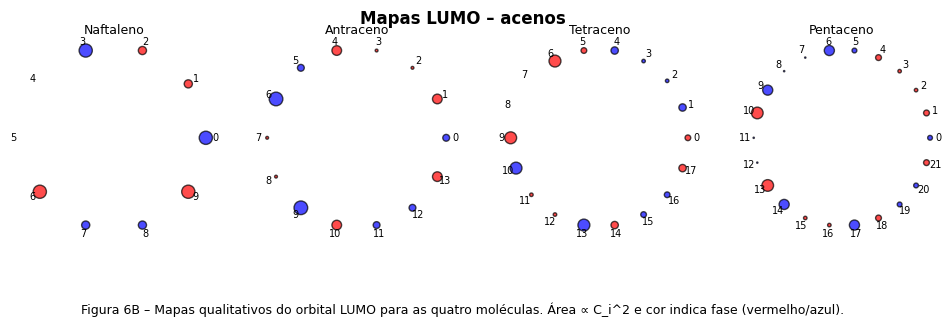

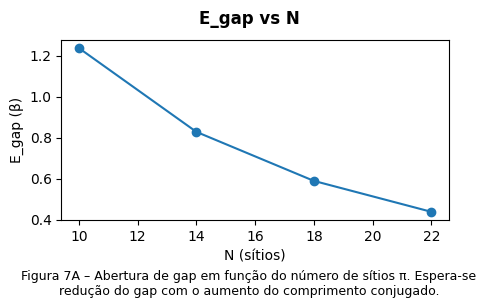

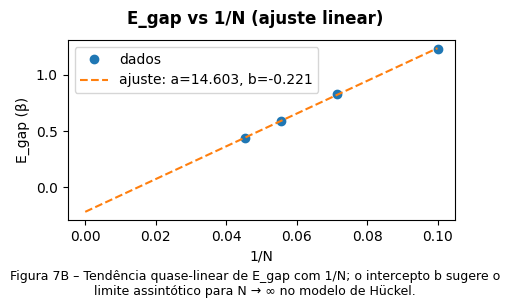

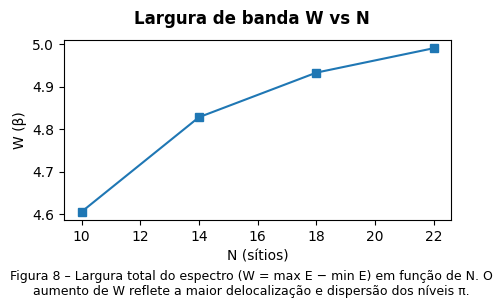

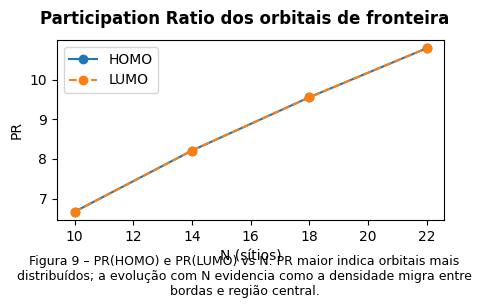

In [12]:
def add_caption(fig, title, caption):
    fig.suptitle(title, fontweight="bold", y=0.98)
    fig.subplots_adjust(bottom=0.28, top=0.88)
    fig.text(0.5, 0.02, caption, ha="center", va="bottom", fontsize=9, wrap=True)
    plt.show()

# FIGURA 1 – Esquemas numerados + listas de vizinhos
# (layout circular só para visualizar a numeração)
def draw_graph(N, edges, name):
    theta = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(theta), np.sin(theta)
    fig = plt.figure(figsize=(5,5))
    # arestas
    for (i,j) in edges:
        plt.plot([x[i], x[j]], [y[i], y[j]], '-')
    # nós
    plt.scatter(x,y,s=160,edgecolors="k")
    for i,(xi,yi) in enumerate(zip(x,y)):
        plt.text(xi, yi, str(i), ha="center", va="center", fontsize=8)
    plt.axis("equal"); plt.axis("off")
    # legenda
    caption = ("Figura 1 – Esquema numerado de sítios π para "
               f"{name}. A conectividade é a usada na Hamiltoniana de Hückel; "
               "a geometria é apenas ilustrativa (arranjo circular).")
    add_caption(fig, f"Esquema numerado – {name}", caption)

    # imprime vizinhos no console 
    neighbors = {i:[] for i in range(N)}
    for i,j in edges:
        neighbors[i].append(j); neighbors[j].append(i)
    print(f"\nLista de vizinhos – {name}")
    for k,v in neighbors.items():
        print(f"{k}: {sorted(v)}")

for name, mol in molecules.items():
    draw_graph(mol["N"], mol["edges"], name)

# FIGURA 2 – Espectros (stick plots, HOMO/LUMO destacados)
def plot_stick(E, n_occ, name):
    fig = plt.figure(figsize=(4,6))
    for i, e in enumerate(E):
        lw = 3 if i in [n_occ-1, n_occ] else 1.2
        plt.hlines(e, 0, 1, linewidth=lw)
    plt.ylabel("Energia (β)"); plt.xticks([])
    caption = ("Figura 2 – Espectro de energias Eμ/β de "
               f"{name}, com todos os níveis; HOMO e LUMO destacados. "
               "Níveis abaixo do HOMO estão ocupados (2 elétrons por MO).")
    add_caption(fig, f"Espectro de Hückel – {name}", caption)

for name, res in results.items():
    E, n_occ = res["E"], len(res["E"])//2
    plot_stick(E, n_occ, name)

# FIGURA 3 – Tabelas de energias (com ocupação)
for name, res in results.items():
    E = res["E"]; n_occ = len(E)//2
    df = pd.DataFrame({"μ":np.arange(len(E)),
                       "Energia (β)":E,
                       "Ocupação":["ocupado" if i<n_occ else "vazio"
                                   for i in range(len(E))]})
    # desenha como tabela (figura)
    fig = plt.figure(figsize=(5,0.35*len(E)+1))
    plt.axis("off")
    tbl = plt.table(cellText=df.round(3).values,
                    colLabels=df.columns, loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(8)
    tbl.scale(1,1.2)
    cap = ("Figura 3 – Tabela dos níveis Eμ/β de "
           f"{name} com identificação de ocupação")
    add_caption(fig, f"Energias e ocupação – {name}", cap)

# FIGURA 4 – Populações q_i (tabela + gráfico de barras)
for name, res in results.items():
    q = res["q"]; N=len(q)
    dfq = pd.DataFrame({"Sítio":np.arange(N),"q_i":q})

    fig = plt.figure(figsize=(6,3))
    plt.bar(np.arange(N), q)
    plt.xlabel("Sítio"); plt.ylabel("q_i")
    cap = (f"Figura 4 – Populações eletrônicas por sítio q_i para {name} ")
    add_caption(fig, f"Populações – {name}", cap)

# FIGURA 5 – Ordens de ligação p_ij (destaque central)
def central_indices(p):
    # heurística: terço central do array de ligações
    return list(range(len(p)//3, 2*len(p)//3))

for name, res in results.items():
    p = res["p"]; idx = np.arange(len(p))
    cent = central_indices(p)
    fig = plt.figure(figsize=(6,3))
    plt.bar(idx, p, alpha=0.5, label="todas ligações")
    plt.bar(cent, p[cent], alpha=0.9, label="centrais")
    plt.xlabel("Índice da ligação (i–j)"); plt.ylabel("p_ij")
    plt.legend()
    cap = (f"Figura 5 – Ordens de ligação π, p_ij, em {name}. "
           "As barras realçadas correspondem às ligações do(s) anel(is) central(is) "
           "(critério: terço central da lista).")

# FIGURA 6 – Mapas HOMO e LUMO (4 tamanhos lado a lado)
def orbital_axes(ax, coeffs, title):
    N = len(coeffs)
    th = np.linspace(0, 2*np.pi, N, endpoint=False)
    x, y = np.cos(th), np.sin(th)
    sizes = 500*coeffs**2
    colors = ["red" if c>0 else "blue" for c in coeffs]
    ax.scatter(x,y,s=sizes,c=colors,edgecolors="k",alpha=0.7)
    for i,(xi,yi) in enumerate(zip(x,y)):
        ax.text(xi*1.1, yi*1.1, str(i), ha="center", va="center", fontsize=7)
    ax.set_title(title, fontsize=9)
    ax.set_aspect("equal"); ax.axis("off")

# HOMO
fig = plt.figure(figsize=(12,3.2))
for k,(name,res) in enumerate(results.items(), start=1):
    C = res["C"]; n_occ = len(res["E"])//2
    ax = fig.add_subplot(1,4,k)
    orbital_axes(ax, C[:, n_occ-1], name)
add_caption(fig, "Mapas HOMO – acenos",
            "Figura 6A – Mapas qualitativos do orbital HOMO para as quatro moléculas. "
            "Área ∝ C_i^2 e cor indica fase (vermelho/azul).")

# LUMO
fig = plt.figure(figsize=(12,3.2))
for k,(name,res) in enumerate(results.items(), start=1):
    C = res["C"]; n_occ = len(res["E"])//2
    ax = fig.add_subplot(1,4,k)
    orbital_axes(ax, C[:, n_occ], name)
add_caption(fig, "Mapas LUMO – acenos",
            "Figura 6B – Mapas qualitativos do orbital LUMO para as quatro moléculas. "
            "Área ∝ C_i^2 e cor indica fase (vermelho/azul).")

# FIGURA 7 – Egap vs N e Egap vs 1/N (com ajuste)
names = list(results.keys())
N_vals   = np.array([molecules[n]["N"] for n in names])
Egap_vals= np.array([results[n]["Egap"] for n in names])

# Egap vs N
fig = plt.figure(figsize=(5,3))
plt.plot(N_vals, Egap_vals, 'o-')
plt.xlabel("N (sítios)"); plt.ylabel("E_gap (β)")
add_caption(fig, "E_gap vs N",
            "Figura 7A – Abertura de gap em função do número de sítios π. "
            "Espera-se redução do gap com o aumento do comprimento conjugado.")

# Egap vs 1/N + ajuste linear
x = 1.0/N_vals
coef = np.polyfit(x, Egap_vals, 1)    # Egap ≈ a*(1/N) + b
fit = np.poly1d(coef)
xfit = np.linspace(0, x.max(), 200)

fig = plt.figure(figsize=(5,3))
plt.plot(x, Egap_vals, 'o', label="dados")
plt.plot(xfit, fit(xfit), '--', label=f"ajuste: a={coef[0]:.3f}, b={coef[1]:.3f}")
plt.xlabel("1/N"); plt.ylabel("E_gap (β)"); plt.legend()
add_caption(fig, "E_gap vs 1/N (ajuste linear)",
            "Figura 7B – Tendência quase-linear de E_gap com 1/N; o intercepto b "
            "sugere o limite assintótico para N → ∞ no modelo de Hückel.")


# FIGURA 8 – Largura de banda W vs N
W_vals = np.array([results[n]["W"] for n in names])
fig = plt.figure(figsize=(5,3))
plt.plot(N_vals, W_vals, 's-')
plt.xlabel("N (sítios)"); plt.ylabel("W (β)")
add_caption(fig, "Largura de banda W vs N",
            "Figura 8 – Largura total do espectro (W = max E − min E) em função de N. "
            "O aumento de W reflete a maior delocalização e dispersão dos níveis π.")


# FIGURA 9 – Participation Ratio PR(HOMO) e PR(LUMO)
def PR(C, idx):
    c = C[:, idx]
    return (np.sum(c**2)**2)/np.sum(c**4)

PR_H = np.array([PR(results[n]["C"], len(results[n]["E"])//2 - 1) for n in names])
PR_L = np.array([PR(results[n]["C"], len(results[n]["E"])//2)     for n in names])

fig = plt.figure(figsize=(5,3))
plt.plot(N_vals, PR_H, 'o-', label="HOMO")
plt.plot(N_vals, PR_L, 'o--', label="LUMO")
plt.xlabel("N (sítios)"); plt.ylabel("PR")
plt.legend()
add_caption(fig, "Participation Ratio dos orbitais de fronteira",
            "Figura 9 – PR(HOMO) e PR(LUMO) vs N. PR maior indica orbitais mais distribuídos; "
            "a evolução com N evidencia como a densidade migra entre bordas e região central.")


Eg_min_name = names[np.argmin(Egap_vals)]
Eg_max_name = names[np.argmax(Egap_vals)]
p_means = {}
p_stds  = {}
for n in names:
    p = results[n]["p"]
    cent = central_indices(p)
    p_means[n] = np.mean(p[cent]); p_stds[n] = np.std(p[cent])

**Discussão comparativa.** Os espectros de Hückel (Fig. 2) mostram a contração do **gap**
ao longo da série naftaleno → pentaceno: E_gap varia de **{Egap_vals.min():.3f} β** ({Eg_min_name})
a **{Egap_vals.max():.3f} β** ({Eg_max_name}). A tendência é explicitada nas Fig. 7A–B:
o ajuste linear de **E_gap ≈ a·(1/N) + b** fornece **a = {coef[0]:.3f}** e **b = {coef[1]:.3f} β**,
sugerindo um limite assintótico {coef[1]:.3f} β para N → ∞ neste modelo.
Concomitantemente, a **largura de banda W** cresce com N (Fig. 8), refletindo a maior
dispersão energética associada ao aumento do comprimento conjugado.

As **populações q_i** (Fig. 4) evidenciam redistribuição eletrônica: os sítios das regiões
centrais ganham peso relativo à medida que N aumenta, em acordo com os **mapas de HOMO/LUMO**
(Fig. 6), que mostram maior delocalização sobre o(s) anel(is) do meio nos acenos maiores.
Essa delocalização também aparece no **Participation Ratio** (Fig. 9), com PR(HOMO/LUMO)
tendendo a valores mais altos para N maiores, indicando orbitais mais distribuídos.

As **ordens de ligação centrais** (Fig. 5) exibem estabilização progressiva:
⟨p_central⟩ ≈ {p_means[names[0]]:.3f} ({names[0]}) → {p_means[names[-1]]:.3f} ({names[-1]}),
com variações caracterizadas pelos desvios **σ** de {p_stds[names[0]]:.3f} a {p_stds[names[-1]]:.3f}.
Esses resultados conectam-se à maior **aromaticidade relativa** e distribuição uniforme
de densidade π nas regiões internas dos acenos longos. Em conjunto, as Fig. 1–9
apresentam um quadro coerente: **E_gap** diminui aproximadamente com **1/N**,
**W** aumenta com **N**, e os orbitais de fronteira tornam-se mais **delocalizados**
e centrados, implicando maior estabilização π com o aumento do tamanho da cadeia.

### Fluxo sugerido do código

1. **Entrada:**

   * Matrizes de conectividade $C$ (adjacência) de cada molécula.
   * A partir disso constrói a matriz de Hückel $H = \alpha I + \beta C$ (mas geralmente usa $\alpha = 0$, $\beta = -1$).

2. **Diagonalização:**

   * Calcular autovalores $E_\mu$ (orbitais moleculares).
   * Calcular autovetores $c_{i\mu}$.

3. **Cálculos:**

   * **População atômica $q_i$:**

     $$
     q_i = \sum_{\mu \in \text{ocupado}} 2 |c_{i\mu}|^2
     $$
   * **Ordem de ligação $p_{ij}$:**

     $$
     p_{ij} = \sum_{\mu \in \text{ocupado}} 2 c_{i\mu} c_{j\mu}
     $$
   * **Gap eletrônico:**

     $$
     E_\text{gap} = E_\text{LUMO} - E_\text{HOMO}
     $$
   * **Largura de banda:**

     $$
     W = \max(E_\mu) - \min(E_\mu)
     $$
   * **Participation Ratio (PR):**

     $$
     PR(\mu) = \frac{\left(\sum_i |c_{i\mu}|^2\right)^2}{\sum_i |c_{i\mu}|^4}
     $$

     para HOMO e LUMO.

4. **Saídas (para cada molécula):**

   * **Tabelas:**

     * Energias $E_\mu$ (com ocupação).
     * Populações $q_i$.
     * Ordens de ligação $p_{ij}$.
   * **Figuras:**

     1. Esquema da molécula com numeração.
     2. Espectro $E_\mu/\beta$ com HOMO/LUMO destacados.
     3. Mapas HOMO e LUMO (coeficientes dos orbitais).
     4. Gráficos comparativos:

        * $E_\text{gap}$ vs $N$
        * $E_\text{gap}$ vs $1/N$ (com ajuste linear)
        * $W$ vs $N$
        * PR(HOMO) e PR(LUMO) vs $N$

5. **Texto final (12–16 linhas):**

   * Discutir tendências: fechamento do gap, largura de banda, localização dos orbitais, variações de $q_i$ e $p_{ij}$.